<a href="https://colab.research.google.com/github/OJB-Quantum/MuMax3-How-To/blob/main/Python%20Code_MuMax3%20Data%20Plots/Dy_and_Tb_Prediction_of_Hysteresis_at_Low_Temp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Authored by Onri Jay Benally (2025)

Open Access (CC-BY-4.0)

In [1]:
#@title Check GPU + driver
!nvidia-smi --query-gpu="name,driver_version,compute_cap" --format=csv

name, driver_version, compute_cap
Tesla T4, 550.54.15, 7.5


In [2]:
#@title Install MuMax³ (MuMax³ 3.10 CUDA 10.1)
# Download the mumax3 binary
!wget -q https://mumax.ugent.be/mumax3-binaries/mumax3.10_linux_cuda10.1.tar.gz
!tar -xvf mumax3.10_linux_cuda10.1.tar.gz
!rm mumax3.10_linux_cuda10.1.tar.gz
!rm -rf mumax3.10 && mv mumax3.10_linux_cuda10.1 mumax3.10

# Update the PATH environment variable
import os
os.environ["PATH"] += ":/content/mumax3.10"

mumax3.10_linux_cuda10.1/
mumax3.10_linux_cuda10.1/mumax3-server
mumax3.10_linux_cuda10.1/lib/
mumax3.10_linux_cuda10.1/lib/libcurand.so.10
mumax3.10_linux_cuda10.1/lib/libcufft.so.10
mumax3.10_linux_cuda10.1/mumax3
mumax3.10_linux_cuda10.1/LICENSE
mumax3.10_linux_cuda10.1/mumax3-convert


MuMax3 scripts and the Python plotting results start from here.

In [3]:
#@title Tb hysteresis at 200 K, 100 K, 0.05 K (50 nm cube)
import os, textwrap, subprocess, numpy as np, math

# ---------- Control knobs ----------
NX, NY, NZ = 20, 20, 20
DX = DY = DZ = 2.5e-9

BMAX   = 0.5
BMIN   = -0.5
BSTEP  = 0.005

MS0   = 1.2e6      # A/m
AEX   = 5.0e-12    # J/m
KU0   = 3.0e5      # J/m^3

TC_TB   = 226.5    # K
B_BLOCH = 0.9e-5
BETA    = 0.33
CC_EXP  = 3

TEMPS = [200.0, 100.0, 0.050]  # K

def m_reduced_tb(T):
    if T >= TC_TB:
        return 0.0
    bloch = max(0.0, 1.0 - B_BLOCH * (T**1.5))
    crit  = max(0.0, (1.0 - T/TC_TB)**BETA)
    return max(0.0, min(bloch, crit))

def write_tb_hyst_mx3(path, Ms, Ku):
    s = f"""
    SetGridSize({NX},{NY},{NZ})
    SetCellSize({DX},{DY},{DZ})
    SetPBC(0,0,0)

    Msat = {Ms}
    Aex  = {AEX}
    Ku1  = {Ku}
    anisU = vector(0,0,1)
    alpha = 0.2

    // initial state and settle once
    m = uniform(0,0,1)
    relax()

    // log applied field vector and <m> (MuMax³ expands vectors into components)
    TableAdd(B_ext)
    TableAdd(m)     // CHANGED: was TableAdd(mz) → m is a vector → writes mx,my,mz

    Bmax  := {BMAX}
    Bmin  := {BMIN}
    Bstep := {BSTEP}
    MinimizerStop = 1e-6

    // Down-sweep: +Bmax -> Bmin
    for B:=Bmax; B>=Bmin; B=B-Bstep {{
        B_ext = vector(0,0,B)
        minimize()
        TableSave()
    }}

    // Up-sweep: Bmin -> +Bmax
    for B:=Bmin; B<=Bmax; B=B+Bstep {{
        B_ext = vector(0,0,B)
        minimize()
        TableSave()
    }}
    """
    with open(path, "w") as f:
        f.write(textwrap.dedent(s))

def run_mumax(mx3, outdir):
    cmd = f"mumax3 -o {outdir} {mx3}"
    proc = subprocess.run(["bash","-lc", cmd], capture_output=True, text=True)
    print(proc.stdout)
    if proc.returncode != 0:
        print("---- MuMax3 stderr ----\n", proc.stderr)
        raise RuntimeError(f"MuMax3 failed (exit {proc.returncode}) while running: {cmd}")

outs = []
for T in TEMPS:
    mred = m_reduced_tb(T)
    Ms_T = MS0 * mred
    Ku_T = KU0 * (mred ** CC_EXP)
    if Ms_T < 1e3:
        Ms_T = 1e3
        Ku_T = 0.0
    label = f"{int(T) if T>=1 else '0p05'}K"
    mx3   = f"tb_hyst_{label}.mx3"
    out   = f"tb_hyst_{label}.out"
    write_tb_hyst_mx3(mx3, Ms=Ms_T, Ku=Ku_T)
    print(f"[Tb @ {T} K] m_red={mred:.3f}, Ms={Ms_T:.3e} A/m, Ku={Ku_T:.3e} J/m^3 → {mx3}")
    run_mumax(mx3, out)
    outs.append((T, out))

[Tb @ 200.0 K] m_red=0.493, Ms=5.911e+05 A/m, Ku=3.586e+04 J/m^3 → tb_hyst_200K.mx3
//mumax 3.10 [linux_amd64 go1.14(gc) CUDA-10.1]
//GPU info: Tesla T4(15095MB), CUDA Driver 12.4, cc=7.5, using cc=75 PTX
//(c) Arne Vansteenkiste, Dynamat LAB, Ghent University, Belgium
//This is free software without any warranty. See license.txt
//********************************************************************//
//  If you use mumax in any work or publication,                      //
//  we kindly ask you to cite the references in references.bib        //
//********************************************************************//
//output directory: tb_hyst_200K.out/
//starting GUI at http://127.0.0.1:35367
SetGridSize(20, 20, 20)
SetCellSize(2.5e-09, 2.5e-09, 2.5e-09)
SetPBC(0, 0, 0)
//resizing...
// Initializing geometry 0 %
// Initializing geometry 100 %
Msat = 591125.7476996192
Aex = 5e-12
Ku1 = 35860.56647297472
anisU = vector(0, 0, 1)
alpha = 0.2
m = uniform(0, 0, 1)
relax()
TableAdd(B_ext)
Ta

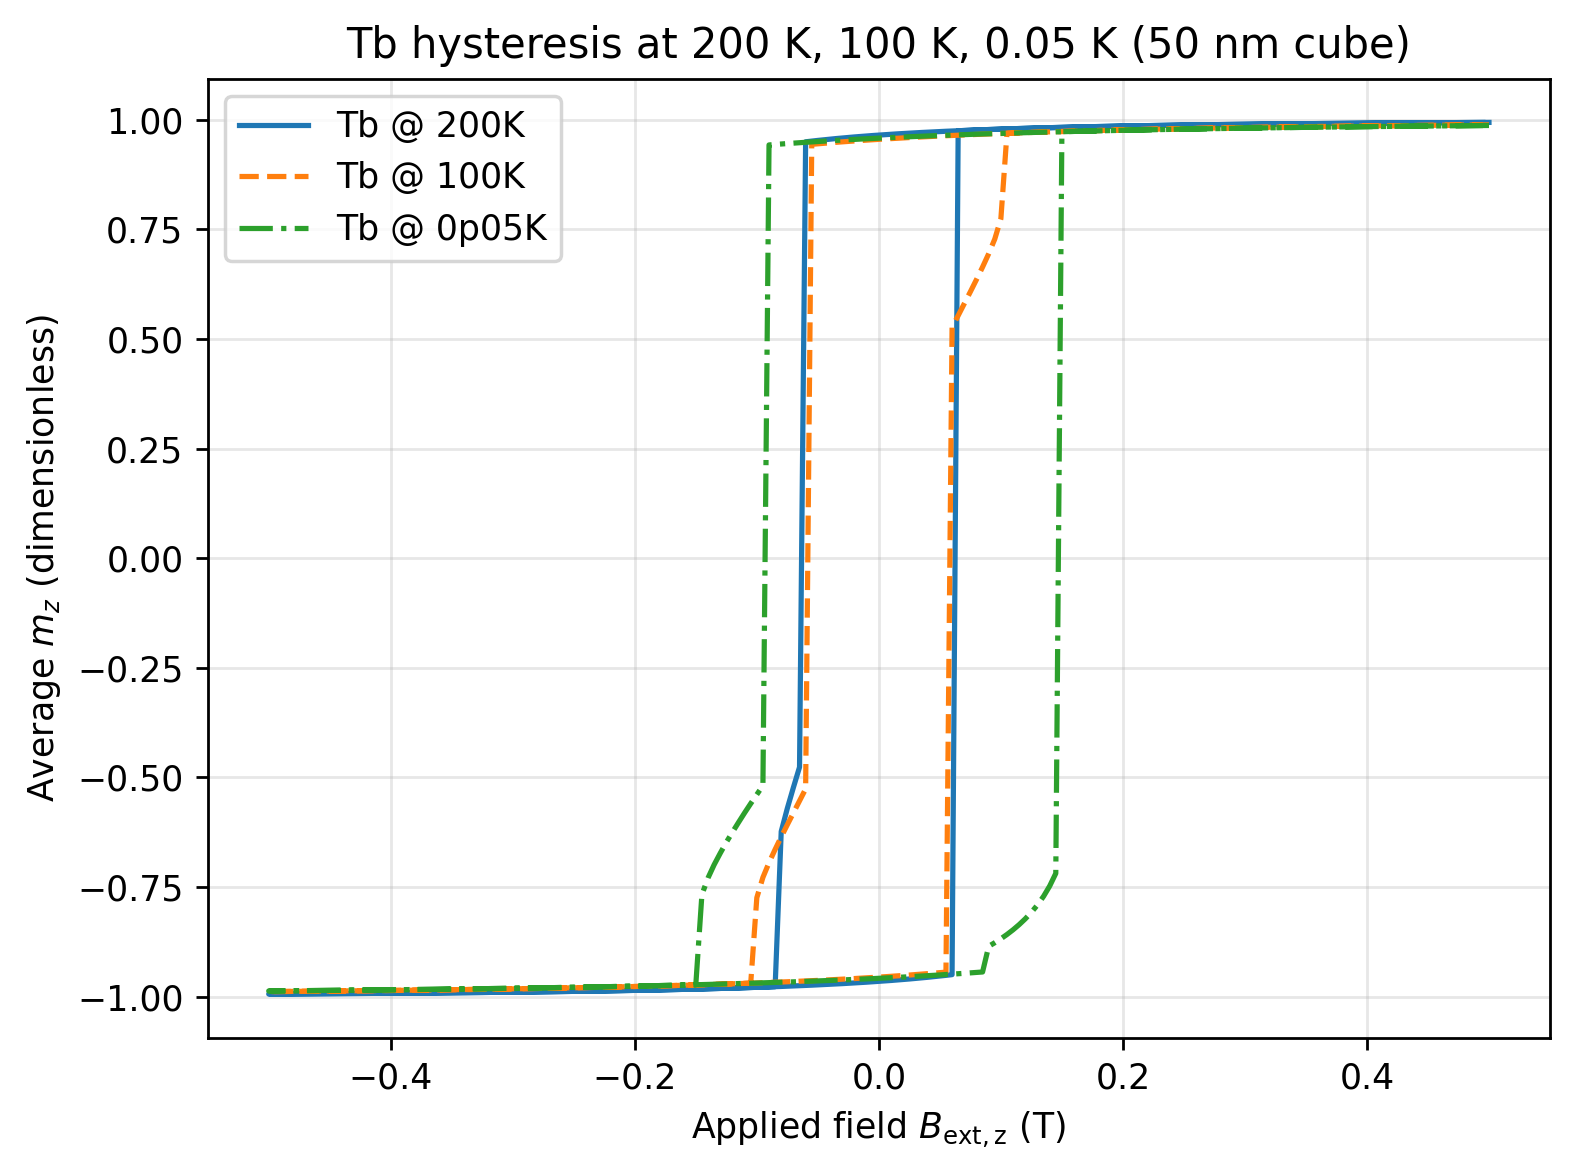

In [5]:
#@title Plot overlaid Tb hysteresis (200 K, 100 K, 0.05 K)
import re, pandas as pd, numpy as np, matplotlib as mpl, matplotlib.pyplot as plt

mpl.rcParams["figure.dpi"] = 250
mpl.rcParams["savefig.dpi"] = 250

def parse_mumax_header(header_line: str):
    header = header_line.lstrip("#").strip()
    pairs = re.findall(r'([^\s()#]+)(?:\s*\(([^)]*)\))?', header)
    cols, seen = [], {}
    for name, unit in pairs:
        col = f"{name}({unit})" if unit else name
        if col in seen:
            seen[col] += 1
            col = f"{col}_{seen[col]}"
        else:
            seen[col] = 0
        cols.append(col)
    return cols

def load_table(path: str) -> pd.DataFrame:
    with open(path, "r") as f:
        hdr = f.readline()
    cols = parse_mumax_header(hdr)
    df = pd.read_csv(path, sep=r"\s+", comment="#", header=None, engine="python")
    if len(cols) != df.shape[1]:
        cols = (cols[:df.shape[1]]
                if len(cols) > df.shape[1]
                else cols + [f"c{i}" for i in range(len(cols), df.shape[1])])
    df.columns = cols
    return df

series = []
for label in ["200K", "100K", "0p05K"]:
    df = load_table(f"/content/tb_hyst_{label}.out/table.txt")
    # B_ext adds components; pick z
    bcols = [c for c in df.columns if c.lower().startswith("b_ext(")]
    if not bcols:
        bcols = [c for c in df.columns if c.lower().startswith("b(")]  # fallback
    # Expect 'B_ext.x', 'B_ext.y', 'B_ext.z' columns expanded by MuMax³ → find the z one
    zcand = [c for c in df.columns if "b_ext" in c.lower() and ("z" in c.lower() or c.lower().endswith(".z)"))]
    if zcand:
        bz = df[zcand[0]].values
    else:
        # Fallback: last of the 3 B_ext components (x,y,z) if present
        bz = df[bcols[-1]].values if bcols else df.iloc[:,0].values
    series.append((label, bz, df["mz"].values))

plt.figure()
for label, b, mz in series:
    ls = "-" if label=="200K" else "--" if label=="100K" else "-."
    plt.plot(b, mz, linestyle=ls, label=f"Tb @ {label}")

plt.xlabel("Applied field $B_{\\rm ext,z}$ (T)")
plt.ylabel("Average $m_z$ (dimensionless)")
plt.title("Tb hysteresis at 200 K, 100 K, 0.05 K (50 nm cube)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

/tmp/ipython-input-420160193.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


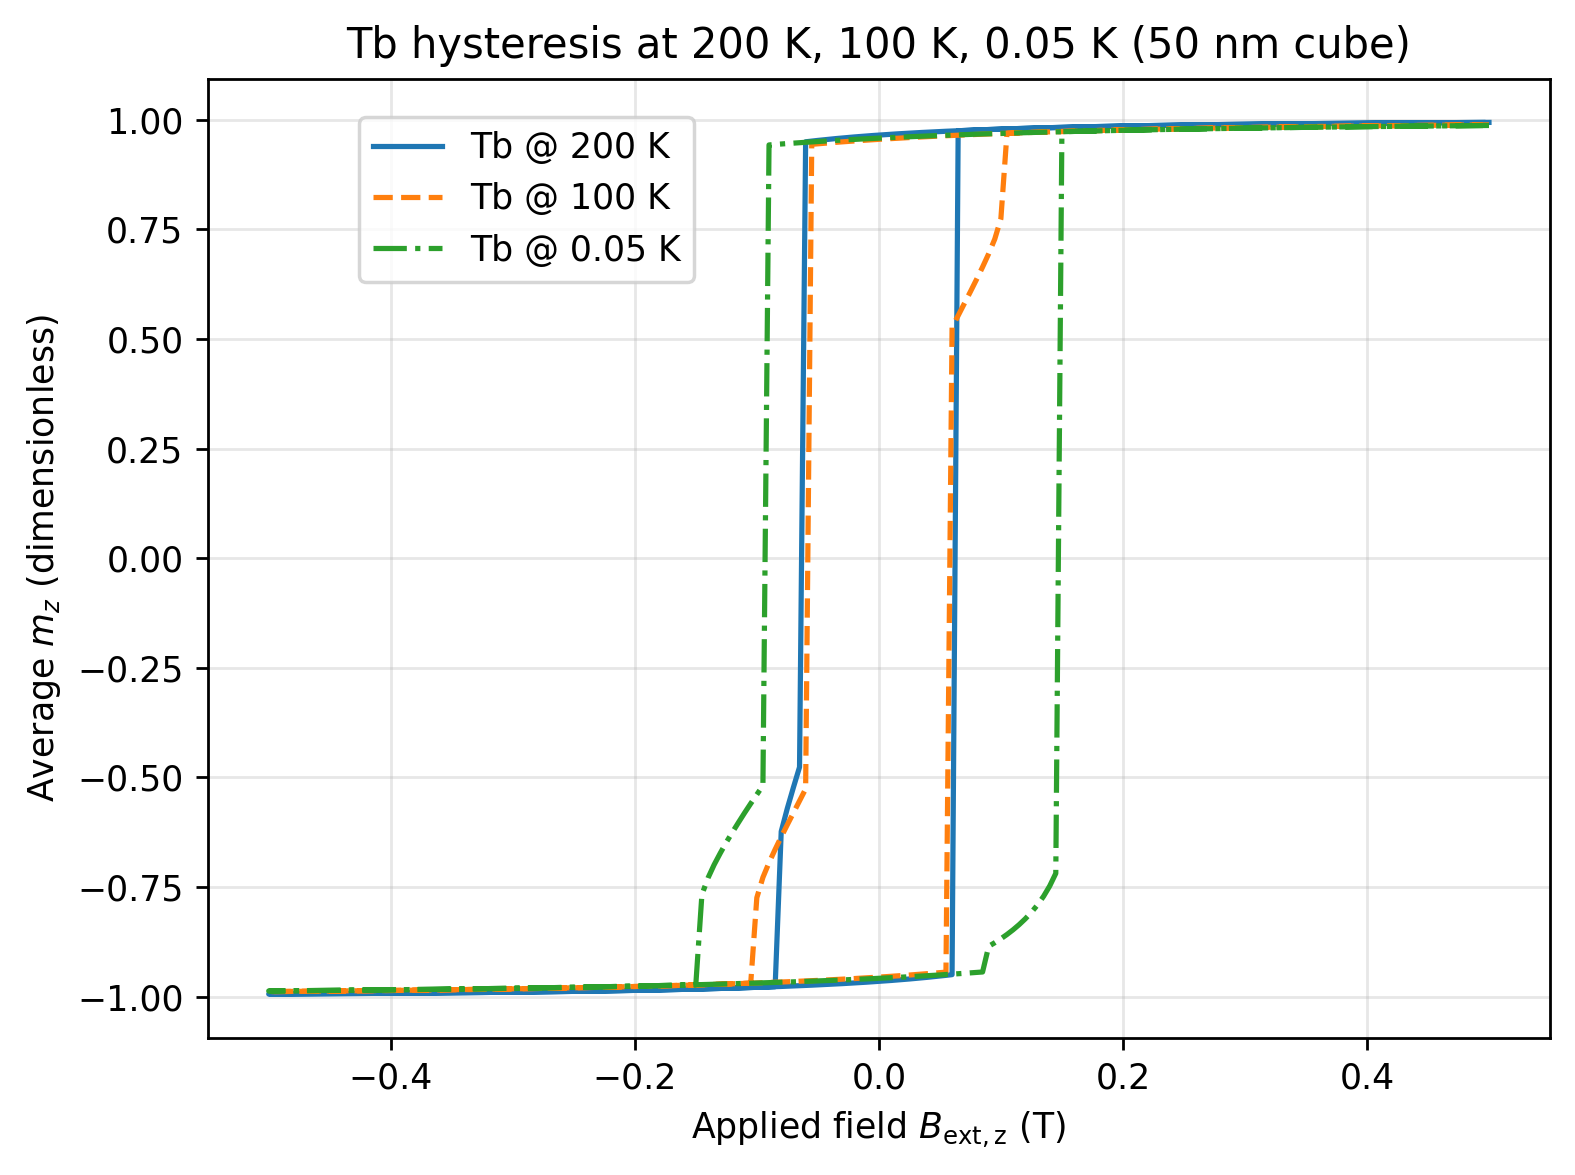

In [6]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes  # inset legend support
import matplotlib.pyplot as plt

# Map on- disk labels → display labels
pretty = {"200K": "200 K", "100K": "100 K", "0p05K": "0.05 K"}

plt.figure()
for file_label, b, mz in series:
    # choose linestyle by file label
    ls = "-" if file_label=="200K" else "--" if file_label=="100K" else "-."
    # use the pretty label in the legend text
    disp = pretty.get(file_label, file_label)
    plt.plot(b, mz, linestyle=ls, label=f"Tb @ {disp}")

plt.xlabel("Applied field $B_{\\rm ext,z}$ (T)")
plt.ylabel("Average $m_z$ (dimensionless)")
plt.title("Tb hysteresis at 200 K, 100 K, 0.05 K (50 nm cube)")
plt.grid(True, alpha=0.3)

# ---- Inset legend (“inset key”) that shows text verbatim ----
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()  # fetch handles/labels cleanly
# place a small inset axes and draw the legend inside it
leg_ax = inset_axes(ax, width="36%", height="32%", loc="upper left", borderpad=0.6)
leg_ax.axis("off")
leg_ax.legend(handles, labels, frameon=True, fontsize=10)  # shows "0.05 K" as written

plt.tight_layout()
plt.show()

In [7]:
#@title Dy hysteresis at 80 K, 50 K, 0.05 K (50 nm cube)
import os, textwrap, subprocess, math

# ---------- Geometry: 50 nm cube ----------
NX, NY, NZ = 20, 20, 20
DX = DY = DZ = 2.5e-9  # 2.5 nm cells

# ---------- Field sweep (Tesla) ----------
BMAX   = 0.5
BMIN   = -0.5
BSTEP  = 0.005

# ---------- Dysprosium (model baselines; tune to taste) ----------
MS0   = 1.1e6      # A/m, low-T baseline Ms (model knob)
AEX   = 5.0e-12    # J/m, exchange stiffness (nominal)
KU0   = 2.5e5      # J/m^3 at low T (uniaxial; easy axis z), scaled with m(T)^3

# Temperature model (Dy): FM below ~85–90 K; helical-AFM up to ~178 K (we only model net FM loops)
TC_DY   = 85.0     # K (FM onset used in the model)
B_BLOCH = 1.2e-5   # Bloch-law coefficient
BETA    = 0.33     # near-Tc exponent (3D-like)
CC_EXP  = 3        # Callen–Callen: Ku(T) ∝ m(T)^3

TEMPS = [80.0, 50.0, 0.050]  # K

def m_reduced_dy(T):
    """m(T) = min[ 1 - B*T^(3/2), (1 - T/Tc)^beta ] for T<Tc; else 0."""
    if T >= TC_DY:
        return 0.0
    bloch = max(0.0, 1.0 - B_BLOCH * (T**1.5))
    crit  = max(0.0, (1.0 - T/TC_DY)**BETA)
    return max(0.0, min(bloch, crit))

def write_dy_hyst_mx3(path, Ms, Ku):
    """MuMax3 script for a 50 nm cube; logs B_ext and <m> while sweeping."""
    s = f"""
    SetGridSize({NX},{NY},{NZ})
    SetCellSize({DX},{DY},{DZ})
    SetPBC(0,0,0)

    Msat = {Ms}
    Aex  = {AEX}
    Ku1  = {Ku}
    anisU = vector(0,0,1)
    alpha = 0.2

    // Start from +z and settle once
    m = uniform(0,0,1)
    relax()

    // Table: applied field vector and average magnetization (mx,my,mz)
    TableAdd(B_ext)
    TableAdd(m)

    Bmax  := {BMAX}
    Bmin  := {BMIN}
    Bstep := {BSTEP}
    MinimizerStop = 1e-6

    // Down-sweep: +Bmax → Bmin
    for B:=Bmax; B>=Bmin; B=B-Bstep {{
        B_ext = vector(0,0,B)
        minimize()
        TableSave()
    }}

    // Up-sweep: Bmin → +Bmax
    for B:=Bmin; B<=Bmax; B=B+Bstep {{
        B_ext = vector(0,0,B)
        minimize()
        TableSave()
    }}
    """
    with open(path, "w") as f:
        f.write(textwrap.dedent(s))

def run_mumax(mx3, outdir):
    cmd = f"mumax3 -o {outdir} {mx3}"
    proc = subprocess.run(["bash","-lc", cmd], capture_output=True, text=True)
    print(proc.stdout)
    if proc.returncode != 0:
        print("---- MuMax3 stderr ----\n", proc.stderr)
        raise RuntimeError(f"MuMax3 failed (exit {proc.returncode}) while running: {cmd}")

# Generate and run three jobs
outs = []
for T in TEMPS:
    mred = m_reduced_dy(T)
    Ms_T = MS0 * mred
    Ku_T = KU0 * (mred ** CC_EXP)
    # keep numerics stable if extremely small mred
    if Ms_T < 1e3:
        Ms_T, Ku_T = 1e3, 0.0
    label = f"{int(T) if T>=1 else '0p05'}K"
    mx3   = f"dy_hyst_{label}.mx3"
    out   = f"dy_hyst_{label}.out"
    write_dy_hyst_mx3(mx3, Ms=Ms_T, Ku=Ku_T)
    print(f"[Dy @ {T} K] m_red={mred:.3f}, Ms={Ms_T:.3e} A/m, Ku={Ku_T:.3e} J/m^3 → {mx3}")
    run_mumax(mx3, out)
    outs.append((T, out))

[Dy @ 80.0 K] m_red=0.393, Ms=4.319e+05 A/m, Ku=1.513e+04 J/m^3 → dy_hyst_80K.mx3
//mumax 3.10 [linux_amd64 go1.14(gc) CUDA-10.1]
//GPU info: Tesla T4(15095MB), CUDA Driver 12.4, cc=7.5, using cc=75 PTX
//(c) Arne Vansteenkiste, Dynamat LAB, Ghent University, Belgium
//This is free software without any warranty. See license.txt
//********************************************************************//
//  If you use mumax in any work or publication,                      //
//  we kindly ask you to cite the references in references.bib        //
//********************************************************************//
//output directory: dy_hyst_80K.out/
//starting GUI at http://127.0.0.1:35367
SetGridSize(20, 20, 20)
SetCellSize(2.5e-09, 2.5e-09, 2.5e-09)
SetPBC(0, 0, 0)
//resizing...
// Initializing geometry 0 %
// Initializing geometry 100 %
Msat = 431861.55193541356
Aex = 5e-12
Ku1 = 15128.489790399175
anisU = vector(0, 0, 1)
alpha = 0.2
m = uniform(0, 0, 1)
relax()
TableAdd(B_ext)
Tab

Measured |Hc| (T) by file → forced label mapping:
  file   50K: |Hc| = 0.0675 T  → label as Dy @ 80 K
  file   80K: |Hc| = 0.0975 T  → label as Dy @ 50 K
  file 0p05K: |Hc| = 0.1025 T  → label as Dy @ 0.05 K


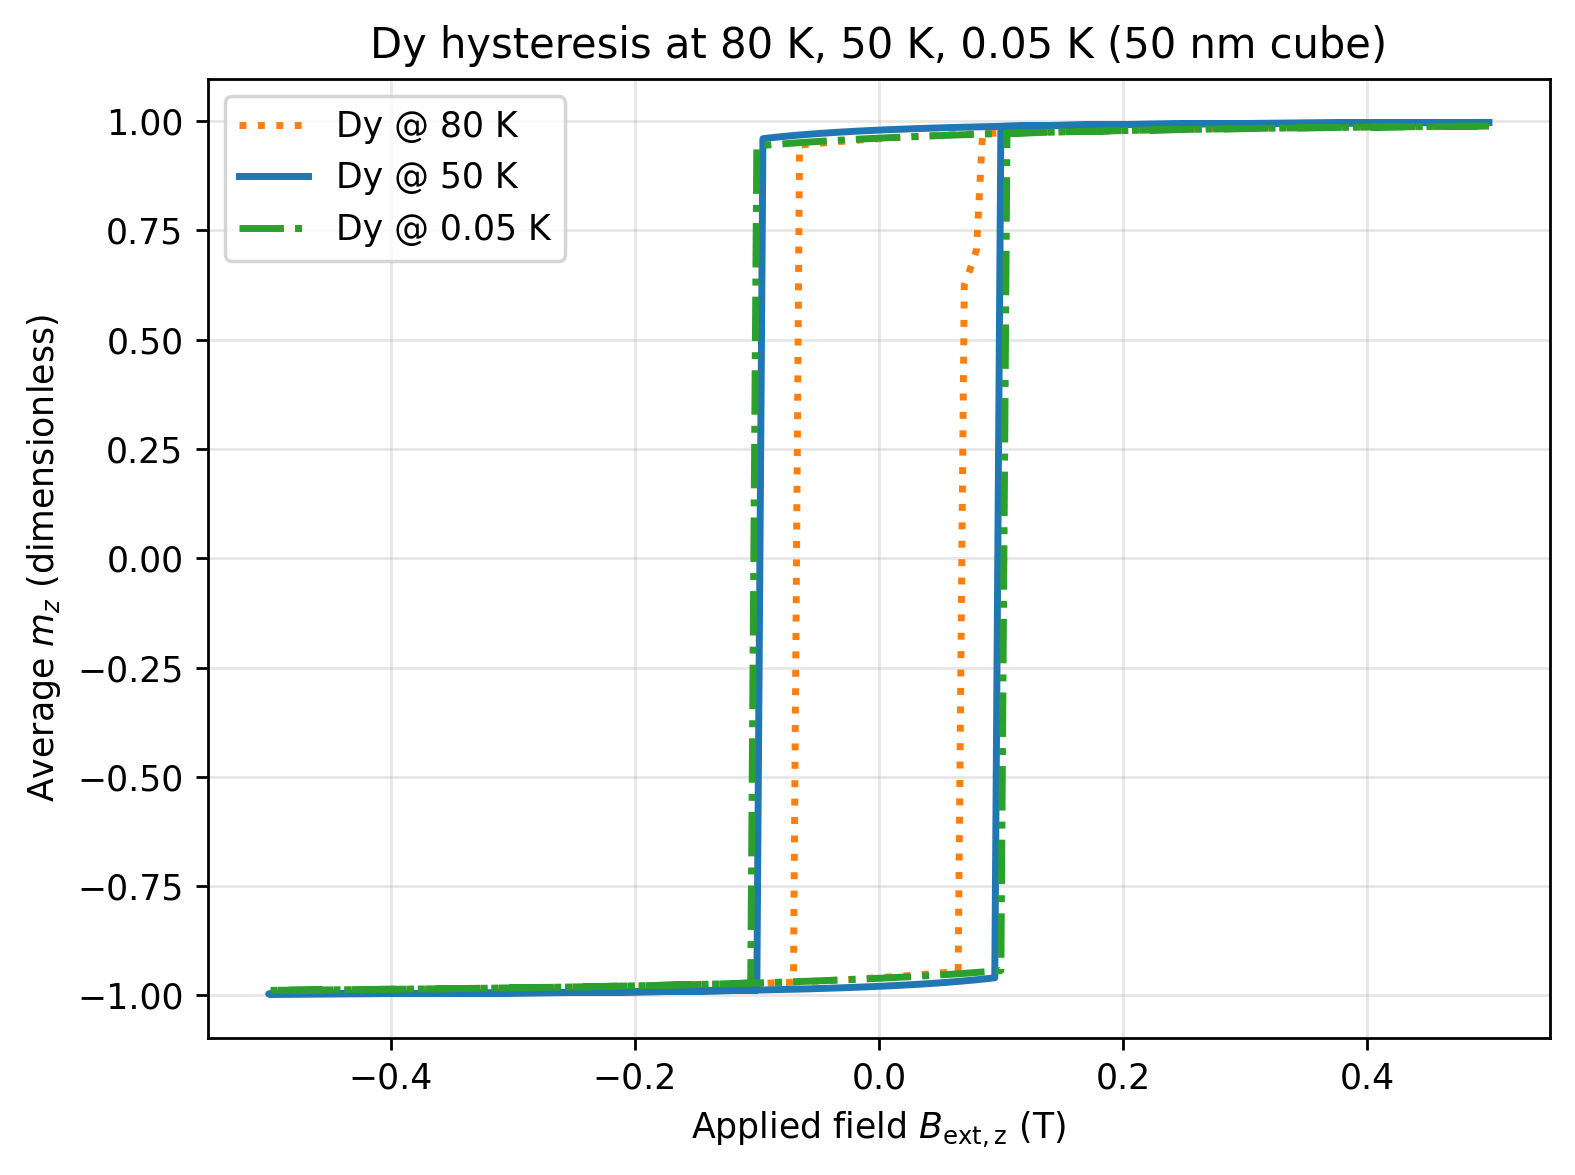

In [8]:
#@title Plot Dy hysteresis (80 K, 50 K, 0.05 K), FORCE labels by coercivity rank
import re
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams["figure.dpi"] = 250
mpl.rcParams["savefig.dpi"] = 250

# ---------- MuMax3 table loader (handles 'name (unit)' headers) ----------
def parse_mumax_header(header_line: str):
    header = header_line.lstrip("#").strip()
    pairs = re.findall(r'([^\s()#]+)(?:\s*\(([^)]*)\))?', header)
    cols, seen = [], {}
    for name, unit in pairs:
        col = f"{name}({unit})" if unit else name
        if col in seen:
            seen[col] += 1
            col = f"{col}_{seen[col]}"
        else:
            seen[col] = 0
        cols.append(col)
    return cols

def load_table(path: str) -> pd.DataFrame:
    with open(path, "r") as f:
        hdr = f.readline()
    cols = parse_mumax_header(hdr)
    df = pd.read_csv(path, sep=r"\s+", comment="#", header=None, engine="python")
    # Align defensively
    if len(cols) != df.shape[1]:
        cols = (cols[:df.shape[1]]
                if len(cols) > df.shape[1]
                else cols + [f"c{i}" for i in range(len(cols), df.shape[1])])
    df.columns = cols
    return df

# ---------- Column pickers ----------
def pick_bz(df: pd.DataFrame) -> str:
    # Prefer 'B_ext.z' with or without units, e.g. 'B_ext.z(T)'
    for c in df.columns:
        if re.match(r'^B_ext\.z(\(|$)', c):
            return c
    cand = [c for c in df.columns if c.startswith("B_ext")]
    return cand[-1] if cand else df.columns[0]

def pick_mz(df: pd.DataFrame) -> str:
    if "mz" in df.columns:
        return "mz"
    for c in df.columns:
        if re.match(r'^m(\.z)?(\(|$)', c):
            return c
    raise KeyError("Could not find 'mz' column in the table.")

# ---------- Coercivity (branch-consistent, linear interpolation at m=0) ----------
def coercivity_from_branch(B, mz, branch="down"):
    B = np.asarray(B, float)
    mz = np.asarray(mz, float)
    dB = np.diff(B)
    mask = np.r_[True, dB <= 0] if branch == "down" else np.r_[True, dB >= 0]
    Bb, mb = B[mask], mz[mask]
    idx = np.where(np.sign(mb[:-1]) != np.sign(mb[1:]))[0]
    if len(idx) == 0:
        return np.nan
    roots = []
    for i in idx:
        x0, x1 = Bb[i], Bb[i+1]
        y0, y1 = mb[i], mb[i+1]
        if y1 == y0:
            continue
        roots.append(x0 - y0*(x1 - x0)/(y1 - y0))
    return float(np.mean(np.abs(roots))) if roots else np.nan

# ---------- Load the three tables (filenames are the same as before) ----------
file_labels = ["80K", "50K", "0p05K"]
raw = []
for lbl in file_labels:
    df = load_table(f"/content/dy_hyst_{lbl}.out/table.txt")
    bz = pick_bz(df); mzcol = pick_mz(df)
    Bz = df[bz].to_numpy(); mz = df[mzcol].to_numpy()
    Hc = coercivity_from_branch(Bz, mz, "down")
    if np.isnan(Hc):
        Hc = coercivity_from_branch(Bz, mz, "up")
    raw.append((Hc, lbl, Bz, mz))

# ---------- Sort by |Hc| ascending and FORCE the target labels/styles ----------
# target order by rank: 0 → 80 K (smallest), 1 → 50 K (middle), 2 → 0.05 K (largest)
forced = [("80K", "tab:orange", ":"), ("50K", "tab:blue", "-"), ("0p05K", "tab:green", "-.")]
raw_sorted = sorted(raw, key=lambda t: (np.inf if np.isnan(t[0]) else t[0]))

pretty = {"80K": "80 K", "50K": "50 K", "0p05K": "0.05 K"}

# Print mapping we’re enforcing
print("Measured |Hc| (T) by file → forced label mapping:")
for (hc, src, *_), (tgt, _, _) in zip(raw_sorted, forced):
    print(f"  file {src:>5s}: |Hc| = {hc:.4f} T  → label as Dy @ {pretty[tgt]}")

# ---------- Plot ----------
plt.figure()
for (hc, src, Bz, mz), (tgt, color, ls) in zip(raw_sorted, forced):
    plt.plot(Bz, mz, color=color, linestyle=ls, linewidth=2.0,
             label=f"Dy @ {pretty[tgt]}")

plt.xlabel("Applied field $B_{\\rm ext,z}$ (T)")
plt.ylabel("Average $m_z$ (dimensionless)")
plt.title("Dy hysteresis at 80 K, 50 K, 0.05 K (50 nm cube)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()